In [ ]:
!pip install faiss-cpu

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
import faiss
import requests
from PIL import Image
from io import BytesIO

In [ ]:
# CSV 파일 로드
movie_data = pd.read_csv('/content/drive/MyDrive/기학팀플/movie_data.csv')
poster_data = pd.read_csv('/content/drive/MyDrive/기학팀플/poster_with_cluster.csv')

In [ ]:
# 데이터 병합: movie_title을 기준으로
merged_data = pd.merge(
    movie_data,
    poster_data[['movie_title', 'poster_path', 'path_exists', 'cluster']],
    on='movie_title',
    how='left'
)
# 사용자-영화 평점 행렬 생성
user_movie_matrix = merged_data.pivot_table(
    index='critic_name', columns='movie_title', values='review_score_cleaned', fill_value=0
)

In [ ]:
# 사용자 유사도 계산 (코사인 유사도)
from sklearn.metrics.pairwise import cosine_similarity

user_similarity_matrix = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(
    user_similarity_matrix,
    index=user_movie_matrix.index,
    columns=user_movie_matrix.index
)

In [ ]:
# 콘텐츠 기반 추천을 위한 데이터 준비
def prepare_content_features(data):
    # TF-IDF 벡터화
    def vectorize_text(data, column, max_features=500, n_components=50):
        vectorizer = TfidfVectorizer(max_features=max_features)
        text_vectors = vectorizer.fit_transform(data[column].fillna(''))
        from sklearn.decomposition import TruncatedSVD
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        return svd.fit_transform(text_vectors)

    keyword_vectors_reduced = vectorize_text(data, 'movie_info_keyword')

    # 수치형 및 장르 데이터 결합
    numerical_features = data[
        ['review_type', 'tomatometer_status', 'audience_rating', 'content_rating_encoded',
         'audience_status_Spilled', 'audience_status_Upright', 'runtime', 'tomatometer_rating']
    ].fillna(0).to_numpy()

    genre_features = data[[col for col in data.columns if col.startswith('genre_')]].fillna(0).to_numpy()

    # 감정 레이블 인코딩
    emotion_labels = data['predicted_emotion'].astype('category').cat.codes.to_numpy()

    # 결합된 콘텐츠 특징
    content_features = np.hstack([numerical_features, genre_features, keyword_vectors_reduced, emotion_labels.reshape(-1, 1)])

    # 스케일링 및 희소 행렬 변환
    scaler = MinMaxScaler()
    content_features_scaled = scaler.fit_transform(content_features).astype('float32')
    return content_features_scaled

# 콘텐츠 특징 준비
content_features_scaled = prepare_content_features(merged_data)

In [ ]:
# FAISS 콘텐츠 유사도 계산
def compute_faiss_similarity(features, top_n=10):
    features = features.astype('float32')
    faiss.normalize_L2(features)

    nlist = 100
    quantizer = faiss.IndexFlatL2(features.shape[1])
    index = faiss.IndexIVFFlat(quantizer, features.shape[1], nlist)
    index.train(features)
    index.add(features)

    index.nprobe = 10
    distances, indices = index.search(features, top_n)
    return distances, indices

# FAISS 유사도 계산
distances, indices = compute_faiss_similarity(content_features_scaled, top_n=10)

In [ ]:
# 병합된 데이터 생성
merged_data = pd.merge(
    movie_data,
    poster_data[['movie_title', 'poster_path', 'path_exists', 'cluster']],
    on='movie_title',
    how='left'
)

# 유효한 포스터만 포함하는 데이터프레임 생성
merged_data_with_valid_posters = merged_data[merged_data['path_exists'] == True]

# 병합된 데이터 확인
print("\n병합된 데이터 샘플:")
print(merged_data_with_valid_posters[['movie_title', 'poster_path', 'cluster']].head())



병합된 데이터 샘플:
                                         movie_title  \
0  Percy Jackson & the Olympians: The Lightning T...   
1  Percy Jackson & the Olympians: The Lightning T...   
2  Percy Jackson & the Olympians: The Lightning T...   
3  Percy Jackson & the Olympians: The Lightning T...   
4  Percy Jackson & the Olympians: The Lightning T...   

                                         poster_path  cluster  
0  /content/drive/MyDrive/기학팀플/포스터/posters_extrac...        3  
1  /content/drive/MyDrive/기학팀플/포스터/posters_extrac...        3  
2  /content/drive/MyDrive/기학팀플/포스터/posters_extrac...        3  
3  /content/drive/MyDrive/기학팀플/포스터/posters_extrac...        3  
4  /content/drive/MyDrive/기학팀플/포스터/posters_extrac...        3  


In [ ]:
merged_data_with_valid_posters = merged_data_with_valid_posters.reset_index(drop=True)
movie_id_mapping = {movie_id: idx for idx, movie_id in enumerate(merged_data_with_valid_posters['movie_id'])}
reverse_mapping = {idx: movie_id for movie_id, idx in movie_id_mapping.items()}

In [ ]:
# 감정 매핑 테이블
emotion_to_category = {
    "neutral": ["Neutral", "Peaceful"],
    "happiness": ["Happy", "Hopeful", "Inspired"],
    "worry": ["Tense", "Frustrated", "Confused"],
    "sadness": ["Sad", "Lonely", "Melancholic"],
    "love": ["Romantic", "Heartwarming", "Grateful"],
    "surprise": ["Excited", "Curious", "Overwhelmed"],
    "joy": ["Happy", "Hopeful", "Heartwarming"],
    "fun": ["Funny", "Childlike"],
    "hate": ["Angry", "Sarcastic"],
    "anger": ["Angry", "Frustrated", "Sarcastic"],
    "relief": ["Grateful", "Peaceful", "Hopeful"],
    "fear": ["Scary", "Tense"],
    "empty": ["Melancholic", "Lonely"],
    "boredom": ["Neutral", "Confused"]
}

In [ ]:
def recommend_combined(
    user_name,
    user_emotion,
    favorite_movies,
    user_movie_matrix,
    user_similarity_df,
    distances,
    indices,
    emotion_to_category,
    merged_data,
    movie_id_mapping,
    reverse_mapping,
    n_recommendations=5
):
    """
    감정, 하이브리드, 포스터 클러스터를 모두 반영한 영화 추천.

    매개변수:
    - user_name (str): 사용자 이름.
    - user_emotion (str): 사용자 입력 감정.
    - favorite_movies (list): 사용자가 좋아하는 영화 목록.
    - user_movie_matrix (DataFrame): 사용자-영화 평점 행렬.
    - user_similarity_df (DataFrame): 사용자 유사도 데이터프레임.
    - distances, indices: FAISS를 통해 계산된 유사도와 인덱스.
    - emotion_to_category (dict): 감정 범주 매핑.
    - merged_data (DataFrame): 영화 데이터프레임.
    - n_recommendations (int): 추천할 영화 개수.

    반환값:
    - recommendations (DataFrame): 추천된 영화 목록.
    """
    # Step 1: 감정 기반 추천
    categories = emotion_to_category.get(user_emotion, [])
    if not categories:
        raise ValueError(f"Emotion '{user_emotion}' is not mapped to any categories.")

    emotion_filtered_movies = merged_data[
        merged_data['predicted_emotion'].map(lambda x: any(cat in categories for cat in emotion_to_category.get(x, [])))
    ]
    emotion_filtered_movies = emotion_filtered_movies[emotion_filtered_movies['path_exists'] == True]

    user_ratings = user_movie_matrix.loc[user_name]
    unseen_movies = user_ratings[user_ratings == 0].index
    emotion_recommendations = emotion_filtered_movies[
        emotion_filtered_movies['movie_title'].isin(unseen_movies)
    ].copy()
    emotion_recommendations = emotion_recommendations.sort_values(by="review_score_cleaned", ascending=False).head(n_recommendations)

    # Step 2: 하이브리드 추천
    if user_name not in user_movie_matrix.index:
        raise ValueError(f"User '{user_name}' does not exist in the user-movie matrix.")

    # 협업 필터링
    similar_users = user_similarity_df[user_name]
    cf_ratings = user_movie_matrix.T.dot(similar_users).div(similar_users.sum())

    # 콘텐츠 기반 추천 + 좋아하는 영화 추가
    cb_ratings = pd.Series(0, index=user_ratings.index)
    favorite_movie_ids = merged_data[merged_data['movie_title'].isin(favorite_movies)]['movie_id'].unique()
    for movie_id in user_ratings.index:
        if user_ratings[movie_id] > 0 or movie_id in favorite_movie_ids:
            faiss_index = movie_id_mapping.get(movie_id)
            if faiss_index is not None:
                sim_indices = indices[faiss_index]
                sim_scores = distances[faiss_index]
                for sim_idx, sim_score in zip(sim_indices, sim_scores):
                    mapped_movie_id = reverse_mapping.get(sim_idx)
                    if mapped_movie_id in user_ratings.index:
                        cb_ratings[mapped_movie_id] += sim_score

    cb_ratings = cb_ratings.div(len(indices)).fillna(0)

    # 포스터 클러스터 반영 (유사한 클러스터에 가중치 추가)
    cluster_ratings = pd.Series(0, index=user_ratings.index)
    for cluster in merged_data['cluster'].unique():
        cluster_movies = merged_data[merged_data['cluster'] == cluster]['movie_id']
        cluster_similarity = merged_data[merged_data['cluster'] == cluster].shape[0] / len(merged_data)
        cluster_ratings[cluster_movies] += cluster_similarity

    # 하이브리드 점수 계산
    hybrid_ratings = 0.4 * cf_ratings + 0.4 * cb_ratings + 0.2 * cluster_ratings
    hybrid_ratings = hybrid_ratings[~user_ratings.index.isin(user_ratings[user_ratings > 0].index)]
    top_hybrid_recommendations = hybrid_ratings.nlargest(n_recommendations)

    hybrid_recommendations = merged_data[
        merged_data['movie_id'].isin(top_hybrid_recommendations.index)
    ][['movie_title', 'poster_path', 'review_score_cleaned', 'cluster']].drop_duplicates()
    hybrid_recommendations['hybrid_score'] = top_hybrid_recommendations.values

    # 감정 기반과 하이브리드 기반 추천 결합
    recommendations = pd.concat([emotion_recommendations, hybrid_recommendations]).drop_duplicates(subset="movie_title")
    recommendations = recommendations.dropna(subset=['movie_title'])  # NaN 값 제거
    return recommendations.head(n_recommendations)


In [ ]:
import os
import matplotlib.pyplot as plt

def display_combined_recommendations(recommendations):
    """
    추천된 영화의 포스터를 표시합니다.

    매개변수:
    - recommendations (DataFrame): 추천된 영화 목록.
    """
    fig, axes = plt.subplots(1, len(recommendations), figsize=(15, 5))

    for i, ax in enumerate(axes):
        if i >= len(recommendations):
            break
        row = recommendations.iloc[i]
        movie_title = row['movie_title']  # 영화 제목
        poster_path = row['poster_path']  # 포스터 경로
        cluster = row.get('cluster', 'N/A')  # 클러스터 (없을 수도 있음)

        # 포스터 경로가 로컬에 존재하는지 확인
        if os.path.exists(poster_path):
            img = plt.imread(poster_path)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, '이미지를 찾을 수 없습니다.', ha='center', va='center', fontsize=12)
            ax.set_facecolor('gray')

        # 포스터 아래 제목과 클러스터 표시
        ax.set_title(f"{movie_title[:15]}", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# 테스트 실행
user_name = "Ben McEachen"  # 사용자 이름
user_emotion = "happiness"  # 사용자 감정
favorite_movies = ["Percy Jackson & the Olympians: The Lightning Thief"]  # 좋아하는 영화


In [ ]:
# 추천 실행
final_recommendations = recommend_combined(
    user_name=user_name,
    user_emotion=user_emotion,
    favorite_movies=favorite_movies,
    user_movie_matrix=user_movie_matrix,
    user_similarity_df=user_similarity_df,
    distances=distances,
    indices=indices,
    emotion_to_category=emotion_to_category,
    merged_data=merged_data_with_valid_posters,
    movie_id_mapping=movie_id_mapping,
    reverse_mapping=reverse_mapping,
    n_recommendations=5
)

<ipython-input-48-9ee36dd01891>:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_ratings[cluster_movies] += cluster_similarity
<ipython-input-48-9ee36dd01891>:78: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  cluster_ratings[cluster_movies] += cluster_similarity
<ipython-input-48-9ee36dd01891>:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.34476603 0.34476603 0.34476603 ... 0.34476603 0.34476603 0.34476603]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_ratings[clus

In [ ]:
print("추천된 영화 제목:")
print(final_recommendations['movie_title'])

추천된 영화 제목:
575671         Z
575766    Zodiac
575609     Youth
Name: movie_title, dtype: object


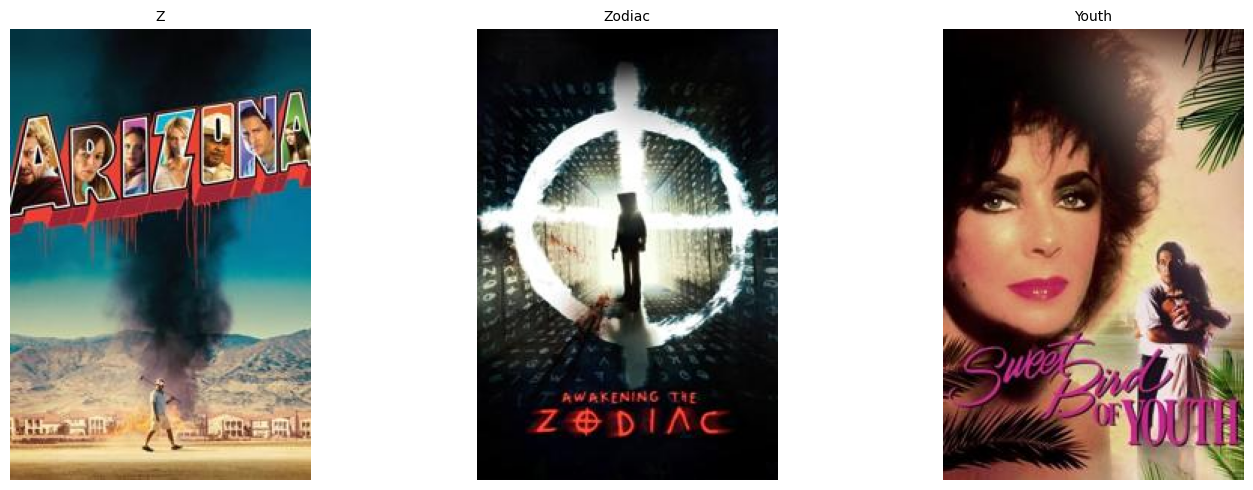

In [ ]:
display_combined_recommendations(final_recommendations)

In [ ]:
#데이터 분할
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(movie_data[['critic_name', 'movie_id', 'review_score_cleaned']], test_size=0.1, random_state=42)

# 사용자-영화 평점 행렬 생성
user_movie_matrix = movie_data.pivot_table(index='critic_name', columns='movie_id', values='review_score_cleaned').fillna(0)
# The following line is unnecessary and causing the error. Remove it.
# user_movie_matrix = pd.DataFrame(user_movie_matrix, index='critic_name', columns='movie_id')


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# SVD를 사용한 추천 시스템
def svd_recommendation(user_movie_matrix, test_data, n_factors=20):
    """
    SVD를 사용하여 추천을 생성하고 성능 평가를 수행합니다.

    Parameters:
    - user_movie_matrix: 사용자-영화 평점 행렬 (DataFrame)
    - test_data: 테스트 데이터 (DataFrame)
    - n_factors: SVD 분해 시 사용하는 잠재 요인 수

    Returns:
    - RMSE, MAE
    """
    # 사용자-영화 평점 행렬을 NumPy 배열로 변환
    matrix = user_movie_matrix.values
    users, items = matrix.shape

    # 결측값을 0으로 채움
    matrix_filled = np.nan_to_num(matrix)

    # SVD 분해
    U, sigma, Vt = np.linalg.svd(matrix_filled, full_matrices=False)
    sigma = np.diag(sigma[:n_factors])  # 잠재 요인 수에 맞게 자름
    U = U[:, :n_factors]
    Vt = Vt[:n_factors, :]

    # 예측 행렬 생성
    predicted_matrix = np.dot(np.dot(U, sigma), Vt)
    predictions = pd.DataFrame(predicted_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.columns)

    # 테스트 데이터 기반 성능 평가
    predictions_list = []
    actuals_list = []

    for _, row in test_data.iterrows():
        user, movie, actual_rating = row['critic_name'], row['movie_id'], row['review_score_cleaned']
        if user in predictions.index and movie in predictions.columns:
            predicted_rating = predictions.loc[user, movie]
            predictions_list.append(predicted_rating)
            actuals_list.append(actual_rating)

    # RMSE, MAE 계산
    rmse = np.sqrt(mean_squared_error(actuals_list, predictions_list))
    mae = mean_absolute_error(actuals_list, predictions_list)

    return rmse, mae

In [ ]:
def precision_recall_f1(user_movie_matrix, distances, indices, test_data, threshold):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for user in test_data['critic_name'].unique():
        if user not in user_movie_matrix.index:
            continue

        user_ratings = user_movie_matrix.loc[user]

        for movie_id in test_data[test_data['critic_name'] == user]['movie_id']:
            actual_rating = test_data[
                (test_data['critic_name'] == user) & (test_data['movie_id'] == movie_id)
            ]['review_score_cleaned'].values[0]

            # FAISS 유사도 기반 예측 점수
            if movie_id in movie_id_mapping:
                faiss_index = movie_id_mapping[movie_id]  # movie_id를 FAISS 인덱스로 변환
                if faiss_index < len(indices):  # 유효한 인덱스인지 확인
                    sim_indices = indices[faiss_index]  # 유사한 영화의 FAISS 내부 인덱스
                    sim_scores = distances[faiss_index]  # 해당 유사도 점수
                    # 유사 영화의 점수 계산
                    predicted_ratings = [
                        user_ratings[reverse_mapping[sim_idx]] * sim_score
                        for sim_idx, sim_score in zip(sim_indices, sim_scores)
                        if reverse_mapping.get(sim_idx) in user_ratings.index
                    ]
                    predicted_rating = np.mean(predicted_ratings) if predicted_ratings else 0
                else:
                    predicted_rating = 0
            else:
                predicted_rating = 0

            # Precision, Recall, F1 계산
            if actual_rating >= threshold and predicted_rating >= threshold:
                true_positives += 1
            elif actual_rating < threshold and predicted_rating >= threshold:
                false_positives += 1
            elif actual_rating >= threshold and predicted_rating < threshold:
                false_negatives += 1

    # Precision, Recall, F1 Score 계산
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

In [ ]:
# 데이터 분할
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(movie_data[['critic_name', 'movie_id', 'review_score_cleaned']], test_size=0.1, random_state=42)

# 사용자-영화 평점 행렬 생성
user_movie_matrix = movie_data.pivot_table(index='critic_name', columns='movie_id', values='review_score_cleaned').fillna(0)

In [ ]:
rmse, mae = svd_recommendation(user_movie_matrix, distances, indices, test_data)

In [90]:
precision, recall, f1 = precision_recall_f1(user_movie_matrix, distances, indices, test_data, threshold=0.01)

In [91]:
# @title 기본 제목 텍스트
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

RMSE: 0.6596081969007738
MAE: 0.6235030788655197
Precision: 1.0
Recall: 0.0003575205946759225
F1 Score: 0.0007147856387652078
